# Estimation-Maximization (EM) Algorithm

In [9]:
import numpy as np
import matplotlib.pyplot as plt

## 0. Constants

In [2]:
N_GAUSSIANS = 5  # Number of Gaussian distributions.
N_SAMPLES = 1000  # Number of samples.

## 1. Dataset

Define helper functions.

In [3]:
def generateRandomCovarianceMatrix(n):
    """Generate a random covariance matrix.

    To generate a covariance matrix, we need to generate a random matrix Q, then
    Q @ Q.T would be a covariance matrix. This method works because Q @ Q.T has
    non-negative diagnonal elements, and it is symmetric and positive
    semidefinite.

    Args:
        n (int): number of dimensions.

    Return (numpy.ndarray ((n, n) & numpy.float64)): a random covariance matrix.
    """
    
    Q = np.random.default_rng().uniform(low=-1, high=1, size=(n, n))
    return Q @ Q.T

def multinoulli(p):
    """Draw one sample from a multinoulli distribution.

    Args:
        p (numpy.ndarray ((n,))): probability mass funtion.

    Return (int): an integer in [0, n) that represents a category.
    """

    # Retrieve the number of categories.
    n = p.shape[0]

    # Normalize the probabilities so that they sum to 1.
    p_normalized = p / p.sum()

    # Sampling.
    rn = np.random.default_rng().uniform(low=0, high=1)
    cummulated_mass = 0
    for i in range(n - 1):
        cummulated_mass += p_normalized[i]
        if rn < cummulated_mass:
            return i
    return n - 1

Generate the probabilities of selecting each Gaussian distribution.

In [4]:
# numpy.ndarray ((N_GAUSSIANS,) & numpy.float64)
p = np.random.default_rng().uniform(size=N_GAUSSIANS)

# Normalize the probabilities so that they sum to 1.
p /= p.sum()

Generate the means of Gaussian distributions.

In [39]:
# numpy.ndarray ((N_GAUSSIANS, 2) & numpy.float64)
means = np.random.default_rng().uniform(low=-5, high=5, size=(N_GAUSSIANS, 2))

Generate the covariance matrices of Gaussian distributions.

In [40]:
covs = []
for i in range(N_GAUSSIANS):
    covs.append(generateRandomCovarianceMatrix(2))

# numpy.ndarray ((N_GAUSSIANS, 2, 2) & numpy.float64)
covs = np.stack(covs)
print(covs)

[[[ 0.47346523 -0.10241004]
  [-0.10241004  0.02441947]]

 [[ 0.69182536  0.94829919]
  [ 0.94829919  1.37169779]]

 [[ 0.32254458  0.2787069 ]
  [ 0.2787069   1.07850465]]

 [[ 0.49499919 -0.13506762]
  [-0.13506762  0.96468331]]

 [[ 0.77353001  0.13408654]
  [ 0.13408654  0.02901567]]]


Sample data points from Gaussian distributions.

In [41]:
points = []
indices = []

for i in range(N_SAMPLES):

    # Sample the index of Gaussian distributions.
    index = multinoulli(p)
    indices.append(index)

    # Sample a point using a specific Gaussian distribution.
    point = np.random.default_rng().multivariate_normal(mean=means[index], cov=covs[index])
    points.append(point)

# numpy.ndarray ((N_SAMPLES, 2) & numpy.float64)
points = np.stack(points)
# numpy.ndarray ((N_SAMPLES,) & numpy.int32)
indices = np.stack(indices)

Visualize data.

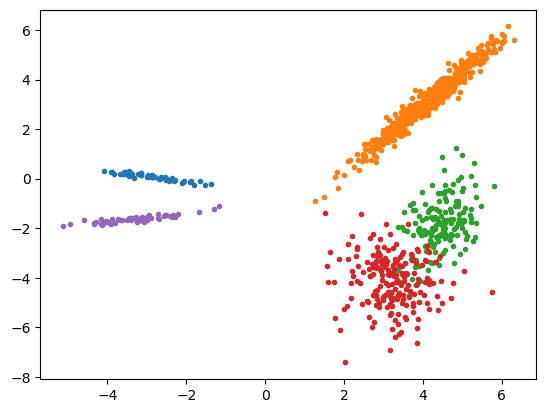

In [47]:
for i in range(N_GAUSSIANS):

    # Get all indices of a single Gaussian distribution.
    indices_single = [] # Indices for a single Gaussian distribution.
    for j in range(N_SAMPLES):
        if indices[j] == i:
            indices_single.append(j)

    plt.plot(points[indices_single,0], points[indices_single,1], '.')

plt.show()